# Sentiment analysis on Tweets
The project will create a model that will be able to predict whether the sentiment of a tweet is positive or genative

## Load the data

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
# Label the columns of our dataset
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
# Drop the columns that we won't need
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
# For this example, we are only keeping 3% of the data but ideally
# we will train with the whole dataset if we had the computation power
df = df.sample(frac=0.03)

# Dictionary to replace the numbers to a Binary classification
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]

# We replace the sentiment values with our binary classification
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

# Print the final data
df.head()

,sentiment,text
680446,Negative,my scalp is burning
1435954,Positive,@ShUtUpAnDlEtMeG Yea it wos good thanx Soriez...
863166,Positive,I will be a medical social worker next semester
707109,Negative,@Terrilw I can't get on my wow account
1188541,Positive,In London all this week and then back for Oas...


## Plot the data 
We plot the data just to make sure everything was correct with our sampling

In [2]:
import matplotlib.pyplot as plt
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

Text(0.5, 1.0, 'Sentiment Data Distribution')

## Preprocessing of the data
We process the data to get rid of noisy values + tokenize the words on the tweets correctly

In [9]:
import nltk
from nltk.corpus import stopwords
import re
import pickle
from nltk.tokenize import TweetTokenizer

# We load stop words from nltk corpus
stop_words = stopwords.words('english')
# We created a regex that will help us clean all of the links that are
# attached in our data
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# For this example, we found a TweetTokenizer which suppose to do a better job
# at tokenize the words on a Tweet
tknzr = TweetTokenizer()
all_words = []

# We define a function that will help us preprocess every row in our data
def preprocess(text, stem=False):
    # We get rid of the links on the tweets + lowercase + blank spaces at the end and beginning
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    # we split into words our tweet
    words = tknzr.tokenize(text)
    for token in words:
        # we get rid of stop_words in our tweet as it wont add any value to our training
        if token not in stop_words:
            # append the token to our all_words array that will help us track the most used words
            all_words.append(token)
            tokens.append(token)
            # return the new tokenized string without stop_words for our data
    return " ".join(tokens)

# we aplly the function that we just create for every row
df.text = df.text.apply(lambda x: preprocess(x))

# we transform the dataframe into a list of tuples with the text and sentiment
documents = []
for index, row in df.iterrows():
    documents.append((row['text'], row['sentiment']))

# save the pickle so we don't have to process again the data
save_doc = open("pickle/tweets.pickle", "wb")
pickle.dump(documents, save_doc)
save_doc.close()

# we sort by most frequent words and we select the top 5000 words used
all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())[:5000]

# save the pickle again so we don't have to process
save_word = open("pickle/word_tweets.pickle", "wb")
pickle.dump(word_features, save_word)
save_word.close()

### Para la implementación de una red LSTM ###

In [5]:
#Para la LSTM
from sklearn.model_selection import train_test_split
train_data_LSTM, test_data_LSTM = train_test_split(df, test_size=1-0.8, random_state=7) 
print("Train Data size:", len(train_data_LSTM))
print("Test Data size", len(test_data_LSTM))

Train Data size: 38400
Test Data size 9600


In [6]:
from keras.preprocessing.text import Tokenizer
# In order to represent word in a way that computer understand
# is used Tokenizer, that encode words with ACSII
tokenizer = Tokenizer(oov_token='<00V>')
tokenizer.fit_on_texts(train_data_LSTM.text)

# The encoding is saved in a dictionary
# word_index are the words
word_index = tokenizer.word_index
# Quantity of differents words used
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 49724


[[0.6359477]
 [0.6096966]]
['Positive', 'Positive']


###  If the preprocessing was done we just load the pickle

In [2]:
import pickle

save_doc = open("pickle/tweets.pickle", "rb")
documents = pickle.load(save_doc)
save_doc.close()

save_word = open("pickle/word_tweets.pickle", "rb")
word_features = pickle.load(save_word)
save_word.close()

## Generating the training and testing dataset
Before we separate the data, we need and extra step which is to create a dictionary for every tweet that will contain which of the most used words was used in that tweet and we will train with that dictionary

In [3]:
# Create the dictionary for every tweet with the most used words and marking
# True for the ones that are actually in our tweet
def find_features(document):
    words = document.split()
    features = {}
    for w in word_features:
        features[w] = (w in words)
    
    return features

In [ ]:
featuresets = [(find_features(rev), category) for (rev, category) in documents]

# Divide our dataset into a 90/10 ratio for training and testing
training_size = int(len(featuresets)*.9)
training_set = featuresets[:training_size]
testing_set = featuresets[training_size:]

# Save the pickle with the featureset
save_featureset = open("pickle/featureset.pickle", "wb")
pickle.dump(featuresets, save_featureset)
save_featureset.close()

### If we already generated the feature set
We just need to load the pickle and separate the training and testing data

In [7]:
save_featureset = open("pickle/featureset.pickle", "rb")
featuresets = pickle.load(save_featureset)
save_featureset.close()

# Divide our dataset into a 90/10 ratio for training and testing
training_size = int(len(featuresets)*.9)
training_set = featuresets[:training_size]
testing_set = featuresets[training_size:]

## Train the models
We generate correctly all of our data for training so we are ready to train the models

In [12]:
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

classifier = nltk.NaiveBayesClassifier.train(training_set)
print('Naive Bayes Algo accuracy percent:', (nltk.classify.accuracy(classifier, testing_set)*100))
classifier.show_most_informative_features(15)
save_class = open("pickle/naive.pickle", "wb")
pickle.dump(classifier, save_class)
save_class.close()

Naive Bayes Algo accuracy percent: 73.20833333333333
Most Informative Features
                   sadly = True           Negati : Positi =     27.0 : 1.0
                 hurting = True           Negati : Positi =     23.7 : 1.0
                    knee = True           Negati : Positi =     20.3 : 1.0
                headache = True           Negati : Positi =     16.5 : 1.0
                 welcome = True           Positi : Negati =     15.8 : 1.0
                   awful = True           Negati : Positi =     15.4 : 1.0
                   hurts = True           Negati : Positi =     15.3 : 1.0
                     sad = True           Negati : Positi =     14.1 : 1.0
              frustrated = True           Negati : Positi =     14.1 : 1.0
                    grrr = True           Negati : Positi =     14.1 : 1.0
               miserable = True           Negati : Positi =     14.1 : 1.0
               depressed = True           Negati : Positi =     13.8 : 1.0
            disappoin

In [ ]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print('MNB classifier Algo accuracy percent:', (nltk.classify.accuracy(MNB_classifier, testing_set)*100))
save_class = open("pickle/mnb.pickle", "wb")
pickle.dump(MNB_classifier, save_class)
save_class.close()

In [6]:
BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print('BernoulliNB classifier Algo accuracy percent:', (nltk.classify.accuracy(BernoulliNB_classifier, testing_set)*100))
save_class = open("pickle/bernoulli.pickle", "wb")
pickle.dump(BernoulliNB_classifier, save_class)
save_class.close()

144000


In [ ]:
SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)
print('SGDClassifier classifier Algo accuracy percent:', (nltk.classify.accuracy(SGDClassifier_classifier, testing_set)*100))
save_class = open("pickle/sgd.pickle", "wb")
pickle.dump(SGDClassifier_classifier, save_class)
save_class.close()

In [ ]:
LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print('LogisticRegression classifier Algo accuracy percent:', (nltk.classify.accuracy(LogisticRegression_classifier, testing_set)*100))
save_class = open("pickle/logistic.pickle", "wb")
pickle.dump(LogisticRegression_classifier, save_class)
save_class.close()

### If we already train all of our models
We just pickle the classifiers so we can move on to testing

In [4]:
import pickle
save_class = open("pickle/naive.pickle", "rb")
classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/mnb.pickle", "rb")
MNB_classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/bernoulli.pickle", "rb")
BernoulliNB_classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/logistic.pickle", "rb")
LogisticRegression_classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/sgd.pickle", "rb")
SGDClassifier_classifier = pickle.load(save_class)
save_class.close()

C:\Users\luis_\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\luis_\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\luis_\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DictVectorizer from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\luis_\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator BernoulliNB from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code o

## Create Vote Classifier
Once we have all of our models ready, we can create a Vote Classifier that will combine the prediction of each different classification model which will allow us to have a confidence on the prediction that we give for real life data.

In [5]:
from nltk.classify import ClassifierI
from statistics import mode

class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)
    
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf
    
# We can add as many classifiers as we want to make it more robust
voted_classifier = VoteClassifier(
    classifier, 
    MNB_classifier, 
    BernoulliNB_classifier,
    LogisticRegression_classifier,
    SGDClassifier_classifier)

In [ ]:
print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set)) * 100)
print("Classification:", voted_classifier.classify(testing_set[0][0]), "Confidence %: ", voted_classifier.confidence(testing_set[0][0])*100)

## We create a function that will call this Vote Classifier
It will receive the text and will return a tople with the classification and the confidence on the result

In [6]:
def sentiment(text):
    feats = find_features(text)
    return voted_classifier.classify(feats), voted_classifier.confidence(feats)

## Evaluation on real time tweets
We made use of the twitter API to get real time tweets and output a result for each of them in real time as well

In [16]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json

#consumer key, consumer secret, access token, access secret.
ckey="3MuY1EnZFbRhfA5utqmqtGRlE"
csecret="TXutBRikoAFG2b1EmZ29xE26O71i9vOM4uuWfnyvD84Y5UfbAz"
atoken="360796736-YqflPUUIK5Dy8QmOmVYJLJPEjuCtQnLK9NovGAL0"
asecret="dmzktdklo30OKGGcnvQkjSZZsgvzLhDijodQwwCVfhfXx"

class listener(StreamListener):

    def on_data(self, data):
        all_data = json.loads(data)
        
        tweet = all_data["text"]
        
        # we call our function to see the sentiment on that tweet
        sentiment_value, confidence = sentiment(tweet)

        # we print the results
        print(tweet, sentiment_value, confidence)
        
        # if we are confident on our prediction, we will save the result for plotting in the next function
        if confidence*100 >= 80:
            output = open("twitter.txt","a")
            output.write(sentiment_value)
            output.write('\n')
            output.close()
        return True

    def on_error(self, status):
        print(status)

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

twitterStream = Stream(auth, listener())
# we select a keyword for we will filter only the tweets related to that word
twitterStream.filter(track=["car"])

@koush Use my referral link to receive 1,000 free Supercharger miles with the purchase and delivery of a new Tesla… https://t.co/cK8wbfwn7V Positive 1.0
RT @stagtattlou: kmm is for when you’re drunk in the back of the car and dlibyh is for when you’re crying like a baby coming home from the… Negative 1.0
Doria tem que cair! Positive 0.8
@climatechangeNU https://t.co/pTKpnor88V Positive 0.8
to the Karen in the car next to me at Taco Bell,

yes they don’t have some stuff...  

maybe next time go to dinner… https://t.co/s3AnmNPVAu Negative 0.6
RT @silvano_trotta: Naples dans la rue ! Pourquoi ? Parce qu’il y a 15 jours ils ont encore élu un mafieux pleutre et couard ! Et maintenan… Positive 1.0
Duvide seriamente do caráter de uma pessoa que não gosta de forró ou piseiro. Que live monstra!

#XandEBaroesComSkol Negative 0.6
RT @TeamOM_Officiel: ▫️ Le onze probable à Lorient :

                 Mandanda ©
Sakai - Álvaro - Ćaleta-Car - Amavi
       Rongier - Kama… Positive 0.8
In today’s inst

KeyboardInterrupt: 

# Plot of the Twitter Analysis
If you want to see the plot in real time, run this script on a separate notebook

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time

style.use("ggplot")

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    pullData = open("twitter.txt","r").read()
    lines = pullData.split('\n')

    xar = []
    yar = []

    x = 0
    y = 0

    for l in lines[-200:]:
        x += 1
        if "Pos" in l:
            y += 1
        elif "Neg" in l:
            y -= 1

        xar.append(x)
        yar.append(y)
        
    ax1.clear()
    ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()

# Same Model Applied to Amazon Reviews #

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid")
np.random.seed(7) 
csv = "1429_1.csv" #Base de datos de reseñas de Amazon
df = pd.read_csv(csv)
data = df.copy()
data.describe()
data["asins"].unique()
asins_unique = len(data["asins"].unique())

### Data Processing ###

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
dataAfter = data.dropna(subset=["reviews.rating"])
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter,
                                           dataAfter["reviews.rating"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)
strat_train["reviews.rating"].value_counts()/len(strat_train)
reviews = strat_train.copy()

In [215]:
reviews.groupby("asins")["name"].unique()
different_names = reviews[reviews["asins"] == 
                          "B00L9EPT8O,B01E6AO69U"]["name"].unique()

In [214]:
reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].value_counts()
corr_matrix = reviews.corr()
counts = reviews["asins"].value_counts().to_frame()
avg_rating = reviews.groupby("asins")["reviews.rating"].mean().to_frame()
table = counts.join(avg_rating)

In [195]:
#Reseñas de 3 estrellas para abajo son consideradas negativas
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif (rating == 2) or (rating == 1) or (rating == 3):
        return "Negative"
strat_train["Sentiment"] = strat_train["reviews.rating"].apply(sentiments)
strat_test["Sentiment"] = strat_test["reviews.rating"].apply(sentiments)
strat_test = strat_test.groupby('Sentiment') # Se balancea para que el número de negativos sea el mismo que el número de positivos
strat_test = strat_test.apply(lambda x: x.sample(strat_test.size().min()).reset_index(drop=True))

In [196]:
X_train = strat_train["reviews.text"]
X_train_targetSentiment = strat_train["Sentiment"]
X_test = strat_test["reviews.text"]
X_test_targetSentiment = strat_test["Sentiment"]
print(len(X_train), len(X_test))

27701 896


In [199]:
# Reemplazar "nan" con espacio
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
X_train_targetSentiment = X_train_targetSentiment.fillna(' ')
X_test_targetSentiment = X_test_targetSentiment.fillna(' ')

from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer()
X_test_counts = count_vect.fit_transform(X_test)

In [216]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [201]:
#Valores predecidos
l = []
it = 0
for i in X_test:
    sentiment_value, confidence = sentiment(i[0])
    if sentiment_value == 'Positive':
        l.append(1)
    else:
        l.append(0)

In [211]:
#Valores numéricos de los sentimientos reales
real_values = strat_test["Sentiment"].tolist()
num_real = []
for i in real_values:
    if i == 'Positive':
        num_real.append(1)
    else:
        num_real.append(0)

num_real = np.array(num_real)

### Resultados con datos de Amazon Reviews ###

In [213]:
from sklearn.metrics import classification_report
print(classification_report(num_real, l))

              precision    recall  f1-score   support

           0       0.43      0.01      0.01       448
           1       0.50      0.99      0.66       448

    accuracy                           0.50       896
   macro avg       0.46      0.50      0.34       896
weighted avg       0.46      0.50      0.34       896



La precisión es muy baja, y de esto podemos concluir que el modelo entrenado para tweets no obtiene una buena precisión al aplicarse para otros casos. Para obtener mejores resultados, sería necesario re-entrenar el modelo con los datos de Amazon, así como se entrenó el modelo para Twitter. 

## Probando la red LSTM ##

In [12]:
from keras.models import load_model
LSTM = load_model('LSTM.h5')

from keras.preprocessing.sequence import pad_sequences
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')
print(LSTM.predict(padded))

def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = LSTM.predict(padded)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(y_pred_1d)

[[0.6359477]
 [0.6096966]]
['Positive', 'Positive']


### Precisión del modelo (ver notebook de LSTM para pasos detallados)  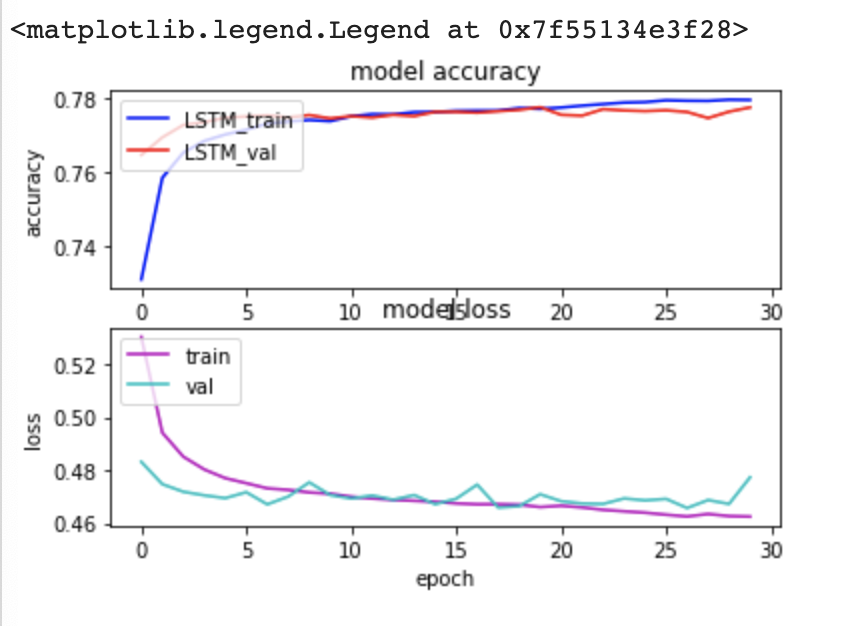

# Same model applied to Speech

## Using Google spech recognition API 

In [ ]:
!pip install ffmpeg-python
!pip3 install --upgrade google-cloud-speech

### Read audio on colab

In [ ]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
import scipy
import wave
from typing import Tuple
audio, sr = get_audio()
scipy.io.wavfile.write('recording.wav', sr, audio)

def read_wav_file(filename) -> Tuple[bytes, int]:
    with wave.open(filename, 'rb') as w:
        rate = w.getframerate()
        frames = w.getnframes()
        buffer = w.readframes(frames)

    return buffer, rate

In [ ]:
# Credentials for google api
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'SkillCortana-bbdb7e323697.json'
from google.cloud import speech
def recognize_audio(filename: str) -> str:
    buffer, rate = read_wav_file(filename)
    client = speech.SpeechClient()

    config = {
        'language_code': 'en-US',
        'sample_rate_hertz': rate,
        'encoding': speech.RecognitionConfig.AudioEncoding['LINEAR16']
    }

    audio = {
        'content': buffer
    }

    response = client.recognize(config=config, audio=audio)
    # For bigger audio file, the previous line can be replaced with following:
    # operation = client.long_running_recognize(config, audio)
    # response = operation.result()

    for result in response.results:
        # First alternative is the most probable result
        alternative = result.alternatives[0]
        return alternative.transcript

### Convert speech and analyze text

In [ ]:
text = recognize_audio("recording.wav")
print(text)
sentiment_value, confidence = sentiment(text)
print(text, sentiment_value, confidence)

## Using Speech Recognition package

In [1]:
!pip install SpeechRecognition
!pip install PyAudio

### Read audio from Microphone

In [15]:
import speech_recognition as sr
r = sr.Recognizer()
with sr.Microphone() as source:
    audio = r.listen(source)

### Convert speech and analyze text

In [14]:
text = r.recognize_google(audio)
print("Text recognized = ", text)
sentiment_value, confidence = sentiment(text)
print("Sentiment analysis on the text = ", sentiment_value, confidence)

Text recognized =  hello my friends I'm really happy to see you
Sentiment analysis on the text =  Positive 1.0


In [16]:
text = r.recognize_google(audio)
print("Text recognized = ", text)
sentiment_value, confidence = sentiment(text)
print("Sentiment analysis on the text = ", sentiment_value, confidence)

Text recognized =  they was an awful day for me
Sentiment analysis on the text =  Negative 1.0
